In [175]:
import pandas as pd
import numpy as np
test__file = '/root/wikipedia/predicted_enwiki-20161201-pages-meta-history11.xml-p003046514p003201200.7z.tsv'
data = pd.read_csv(test__file, sep='\t')

# Class DATA:
the class data needs to provide following functions:

* **`buildCorpora()`** extracting unique words from user specified columns

* **`getWordVectors()`** extract words vectors using Facebook's library

* **`_computeSentenceVectorsUncombined()`** extract words vectors using Facebook's library

* **`tsneDimReduction()`** dimensionality reduction using TSNE

* **`computeSentenceVectors()`** combine wordvectors 
* **`computeWordVectors()`** combine wordvectors 

In [176]:
import string
import os
import subprocess 
import pandas as pd
import numpy as np
from MulticoreTSNE import MulticoreTSNE as TSNE


class WIKIDATA:
    
    def __init__(self, data):
        self.data = data

        
        
    def buildCorpora(self, text_cols):
        assert [col in data.columns for col in text_cols]

        corpora = set()
        for col in text_cols:
            _corpora = self._extractUniqueWordsFromColumn(col)
            corpora = corpora.union(_corpora)
        return corpora

    
    
    def _extractUniqueWordsFromColumn(self, text_col):
        _data = data[text_col]
        unique_words = set()
        punc_table = str.maketrans({key: None for key in string.punctuation})

        for item in _data.items():
            text = item[1]
            if(type(text) is not str):
                continue

            # remove punctuations
            text = text.translate(punc_table)
            for word in text.split():
                if len(word) > 50:
                    # eg. "http ... "
                    pass
                elif word not in unique_words:
                    unique_words.add(word)
                else:
                    pass

        return unique_words    
    
    

    def computeVectors(self, source_file, mode='', identifier='', ft_dir='.', bin_dir='.'):
        assert os.path.exists(ft_dir)
        assert os,path.exists(bin_dir)
        assert mode in ['word', 'sentence']

        ft_dir = os.path.join(ft_dir, 'fastText', 'fasttext')
        bin_dir = os.path.join(bin_dir, 'wiki.en.bin')
        target_dir = '__vectors_%s.txt'%identifier
        func = 'print-%s-vectors'%(mode)

        # save the file to txt
        if mode is 'word':
            source_dir = '__source_file_%s.txt'%identifier
            assert type(source_file) is set
            with open(source_dir,'w') as file:
                file.writelines(["%s\n" % item  for item in source_file])
        if mode is 'sentence':
            source_dir = '__source_file_%s.csv'%identifier
            assert type(source_file) is pd.core.series.Series
            source_file.to_csv(source_dir, index=False)

        # compute the word vectors
        command = "sh -c \'%s %s %s < %s > %s\' "%(ft_dir, 
                                                        func, 
                                                        bin_dir, 
                                                        source_dir, 
                                                        target_dir)

        print('Copy files to UNC server')
        print('scp -i ~/alexguo.pem',
              'ubuntu@ec2-52-87-42-119.compute-1.amazonaws.com:/home/ubuntu/wikipedia/Visualization/%s'%source_dir,
              '.')
        print('\n Execute the files')
        print(command)
        print('\n Copy them back')
        print('scp -i ~/alexguo.pem',
              '%s'%target_dir, 
              'ubuntu@ec2-52-87-42-119.compute-1.amazonaws.com:/home/ubuntu/%s'%target_dir)
        print('\n Excute in AWS')
        print('sudo mv ~/%s .'%target_dir)

        print('Please Use UNC Server')

        # subprocess.call(command, shell=True)

        # load them back
        #lookup_dict = loadWordVectors(file=target_dir)    

        #return lookup_dict

    
    
    def _computeSentenceVectorsUncombined(self, text_cols):
        assert [col in data.columns for col in text_cols]
    
        for col in text_cols:
            texts = data[col]
            # replace nan with ''
            texts_cleaned = texts.apply(lambda x: "" if type(x) is not str else x)
            # remove empty lines within one row
            texts_cleaned = texts_cleaned.apply(lambda x: x.replace('\n', ''))
            self.computeVectors(texts_cleaned, mode='sentence', identifier=col)

    
    
    def to_csv(self, filedir, drop_text=True):
        if drop_text is True:
            _data = data.drop('text', axis=1)
            _data.to_csv(filedir)
        else:
            data.to_csv(filedir)

        print('scp -i ~/Desktop/alexguo.pem ubuntu@ec2-52-87-42-119.compute-1.amazonaws.com:/home/ubuntu/wikipedia/Visualization/%s ~/Documents/UNC/Research'%filedir)
    
    
    
    def computeSentenceVectors(self, dim=300):
        assert [os.path.exists('_vectors_%s.txt'%f) for f in ['Added', 'Deleted']]
        assert 'title' in data.columns

        sentenceVec_Added = WIKIDATA.loadVectors('__vectors_Added.txt', mode='sentence')
        sentenceVec_Deleted = WIKIDATA.loadVectors('__vectors_Deleted.txt', mode='sentence')

        title_prev = ''
        sentenceVectors = np.zeros([data.shape[0], dim])
        sentenceVectorsCentered = np.zeros([data.shape[0], dim])

        for row in data.iterrows():
            title = row[1]['title']
            idx = row[0]
            delta_vector = sentenceVec_Added.get(idx) - sentenceVec_Deleted.get(idx)

            if title is not title_prev:
                sentenceVectors[idx, :] = delta_vector
                sentenceVectorsCentered[idx, :] = np.zeros([dim])
            if title is title_prev:
                sentenceVectors[idx, :] = sentenceVectors[idx-1, :] + delta_vector
                sentenceVectorsCentered[idx, :] = sentenceVectorsCentered[idx-1, :] + delta_vector

            title_prev = title

        sentenceVectors_TSNE = WIKIDATA.tsneDimReduction(sentenceVectors)
        sentenceVectorsCentered_TSNE = WIKIDATA.tsneDimReduction(sentenceVectorsCentered)

        data['sentenceVecDim1'] = sentenceVectors_TSNE[:,0]
        data['sentenceVecDim2'] = sentenceVectors_TSNE[:,1]
        data['sentenceVecCenteredDimCenter1'] = sentenceVectorsCentered_TSNE[:,0]
        data['sentenceVecCenteredDimCenter2'] = sentenceVectorsCentered_TSNE[:,1]

        return data

    
    
    def computeWordVectors(self, dim=300):
        assert [os.path.exists('_vectors_%s.txt'%f) for f in ['Added', 'Deleted']]
        assert 'title' in data.columns

        wordVectors = WIKIDATA.loadVectors('__vectors_.txt', mode='word')
        title_prev = ''
        cumWordVectors = np.zeros([data.shape[0], dim])
        cumWordVectorsCentered = np.zeros([data.shape[0], dim])

        for row in data.iterrows():
            title = row[1]['title']
            idx = row[0]
            addedWords = row[1]['Added']
            deletedWords = row[1]['Deleted']


            addVec = np.zeros(dim)
            if type(addedWords) is str:
                for aWord in addedWords:
                    if wordVectors.get(aWord) is not None:
                        addVec += wordVectors.get(aWord)
            delVec = np.zeros(dim)
            if type(deletedWords) is str:
                for dWord in deletedWords:
                    if wordVectors.get(dWord) is not None:
                        delVec += wordVectors.get(dWord)
            delta_vector = addVec - delVec

            if title is not title_prev:
                cumWordVectors[idx, :] = delta_vector
                cumWordVectorsCentered[idx, :] = np.zeros([dim])
            if title is title_prev:
                cumWordVectors[idx, :] = cumWordVectors[idx-1, :] + delta_vector
                cumWordVectorsCentered[idx, :] = cumWordVectorsCentered[idx-1, :] + delta_vector
                
            title_prev = title

        cumWordVectors_TSNE = WIKIDATA.tsneDimReduction(cumWordVectors)
        cumWordVectorssCentered_TSNE = WIKIDATA.tsneDimReduction(cumWordVectorsCentered)

        data['wordVecDim1'] = cumWordVectors_TSNE[:,0]
        data['wordVecDim2'] = cumWordVectors_TSNE[:,1]
        data['wordVecDimCenteredDimCenter1'] = cumWordVectorssCentered_TSNE[:,0]
        data['wordVecDimCenteredDimCenter2'] = cumWordVectorssCentered_TSNE[:,1]

        return data
        
    
    

    ############## Class Methods ############
    
    def loadVectors(file, mode, dim=300):
        assert mode in ['word', 'sentence']
        lookup_dict = {}

        if mode is 'word':
            with open(file) as f:
                for line in f:
                    key = line.split()[0]
                    values = line.split()[-dim:]
                    values = [float(v) for v in values]
                    lookup_dict[key] = np.array(values)

        if mode is 'sentence':
            with open(file) as f:
                idx = 0
                for line in f:
                    key = idx
                    values = line.split()[-dim:]

                    if values[0] in ['-nan' or 'nan']: 
                        lookup_dict[key] = np.zeros([dim])
                    else:
                        values = [float(v) for v in values]
                        lookup_dict[key] = np.array(values)

                    idx += 1
        
        return lookup_dict
    
    
    
    def tsneDimReduction(M, new_dim=2):
        model = TSNE(n_jobs=16, n_components=new_dim)
        vec_tsne = model.fit_transform(M)
        return vec_tsne

# TEST

In [177]:
D = WIKIDATA(data)

### TEST: Will Multiprocessing Help Extracting Unique Words?
Conclusion: the time taken is too small for multiprocessing to take effect

In [178]:
%%time
words1 = D._extractUniqueWordsFromColumn('Added')
words2 = D._extractUniqueWordsFromColumn('Deleted')

CPU times: user 396 ms, sys: 8 ms, total: 404 ms
Wall time: 404 ms


### TEST: buildCorpora
Except the new version excludes a few unnecessary tokens. The rest is pretty good

In [179]:
words_groundtruth = []
with open('test__corpus.txt') as f:
    for line in f:
        words_groundtruth.append(line.strip('\n'))
words_groundtruth = set(words_groundtruth)

In [180]:
words = D.buildCorpora(['Added', 'Deleted'])

In [181]:
words_groundtruth.difference(words);

### TEST: get/loadWordVectors
It seems like the official release of `wiki.en.bin` has changed. This is confirmed by running fasttext on command line. The word vector for 'a' was changed.

In [182]:
%%time
wordvecs_groundtruth = WIKIDATA.loadVectors('test__wordvecs.txt', mode='word')
D.computeVectors(words, mode='word')

Copy files to UNC server
scp -i ~/alexguo.pem ubuntu@ec2-52-87-42-119.compute-1.amazonaws.com:/home/ubuntu/wikipedia/Visualization/__source_file_.txt .

 Execute the files
sh -c './fastText/fasttext print-word-vectors ./wiki.en.bin < __source_file_.txt > __vectors_.txt' 

 Copy them back
scp -i ~/alexguo.pem __vectors_.txt ubuntu@ec2-52-87-42-119.compute-1.amazonaws.com:/home/ubuntu/__vectors_.txt

 Excute in AWS
sudo mv ~/__vectors_.txt .
Please Use UNC Server
CPU times: user 3.75 s, sys: 100 ms, total: 3.85 s
Wall time: 4.25 s


In [183]:
wordvecs = WIKIDATA.loadVectors('__vectors_.txt', mode='word')

In [184]:
print('Ground Truth:')
print(wordvecs_groundtruth.get('a')[:10])
print('\n\nPredicted')
print(wordvecs.get('a')[:10])

Ground Truth:
[ 0.11559    0.30192   -0.11465    0.01001   -0.032187  -0.10755    0.060674
 -0.10477    0.17488    0.0081116]


Predicted
[-0.034038  0.10799  -0.077366  0.030302  0.11785  -0.10739  -0.049401
 -0.30882   0.074382 -0.014087]


### TEST: _computeSentenceVectorsUncombined
Passed

In [185]:
ca = D._computeSentenceVectorsUncombined(['Added'])
cd = D._computeSentenceVectorsUncombined(['Deleted'])
sentenceVec_a = WIKIDATA.loadVectors('__vectors_Added.txt', mode='sentence')
sentenceVec_d = WIKIDATA.loadVectors('__vectors_Deleted.txt', mode='sentence')

Copy files to UNC server
scp -i ~/alexguo.pem ubuntu@ec2-52-87-42-119.compute-1.amazonaws.com:/home/ubuntu/wikipedia/Visualization/__source_file_Added.csv .

 Execute the files
sh -c './fastText/fasttext print-sentence-vectors ./wiki.en.bin < __source_file_Added.csv > __vectors_Added.txt' 

 Copy them back
scp -i ~/alexguo.pem __vectors_Added.txt ubuntu@ec2-52-87-42-119.compute-1.amazonaws.com:/home/ubuntu/__vectors_Added.txt

 Excute in AWS
sudo mv ~/__vectors_Added.txt .
Please Use UNC Server
Copy files to UNC server
scp -i ~/alexguo.pem ubuntu@ec2-52-87-42-119.compute-1.amazonaws.com:/home/ubuntu/wikipedia/Visualization/__source_file_Deleted.csv .

 Execute the files
sh -c './fastText/fasttext print-sentence-vectors ./wiki.en.bin < __source_file_Deleted.csv > __vectors_Deleted.txt' 

 Copy them back
scp -i ~/alexguo.pem __vectors_Deleted.txt ubuntu@ec2-52-87-42-119.compute-1.amazonaws.com:/home/ubuntu/__vectors_Deleted.txt

 Excute in AWS
sudo mv ~/__vectors_Deleted.txt .
Please Use

In [186]:
sentenceVec_d.get(8251);

### TEST: tsneDimReduction
passed

In [137]:
import pandas as pd
dictDF = pd.DataFrame.from_dict(sentenceVec_a, orient='index')
sentenceVec_TSNE = WIKIDATA.tsneDimReduction(dictDF.values)
# data['sentenceVecDim1'] = sentenceVec_TSNE[:,0]
# data['sentenceVecDim2'] = sentenceVec_TSNE[:,1]
# to_csv(data, filedir='test__sentenceVec.csv', drop_text=True)

In [22]:
# to_csv(data, filedir='test__sentenceVec.csv', drop_text=True)

scp -i ~/Desktop/alexguo.pem ubuntu@ec2-52-87-42-119.compute-1.amazonaws.com:/home/ubuntu/wikipedia/Visualization/test__sentenceVec.csv ~/Documents/UNC/Research


### TEST: computeSentenceVectors
passed

In [187]:
newdata = D.computeSentenceVectors()

### TEST: computeSentenceVectors
passed

In [188]:
newdata = D.computeWordVectors()

In [189]:
D.to_csv(filedir='test__cumWordVecs.csv', drop_text=True)

scp -i ~/Desktop/alexguo.pem ubuntu@ec2-52-87-42-119.compute-1.amazonaws.com:/home/ubuntu/wikipedia/Visualization/test__cumWordVecs.csv ~/Documents/UNC/Research


* **`findNearestNeighbor()`** combine wordvectors 

In [21]:
from sklearn.neighbors import NearestNeighbors
def findNearestNeighbor(data, vec_cols, query_idx, k):
    assert [col in data.columns for col in vec_cols]
    M = data[vec_cols].values
    model = NearestNeighbors().fit(M)
    query = M[query_idx,:]
    dist, idx = model.kneighbors(query, k)
    
    return dist, idx

def printNearestResult(data, query_idx, result_idx):
    
    
    

In [23]:
model = findNearestNeighbor(data, ['sentenceVecCenteredDimCenter1', 'sentenceVecCenteredDimCenter2'], 0, 1)

In [29]:
to_csv(newdata,'test__sentenceVec.csv', drop_text=True)

scp -i ~/Desktop/alexguo.pem ubuntu@ec2-52-87-42-119.compute-1.amazonaws.com:/home/ubuntu/wikipedia/Visualization/test__sentenceVec.csv ~/Documents/UNC/Research


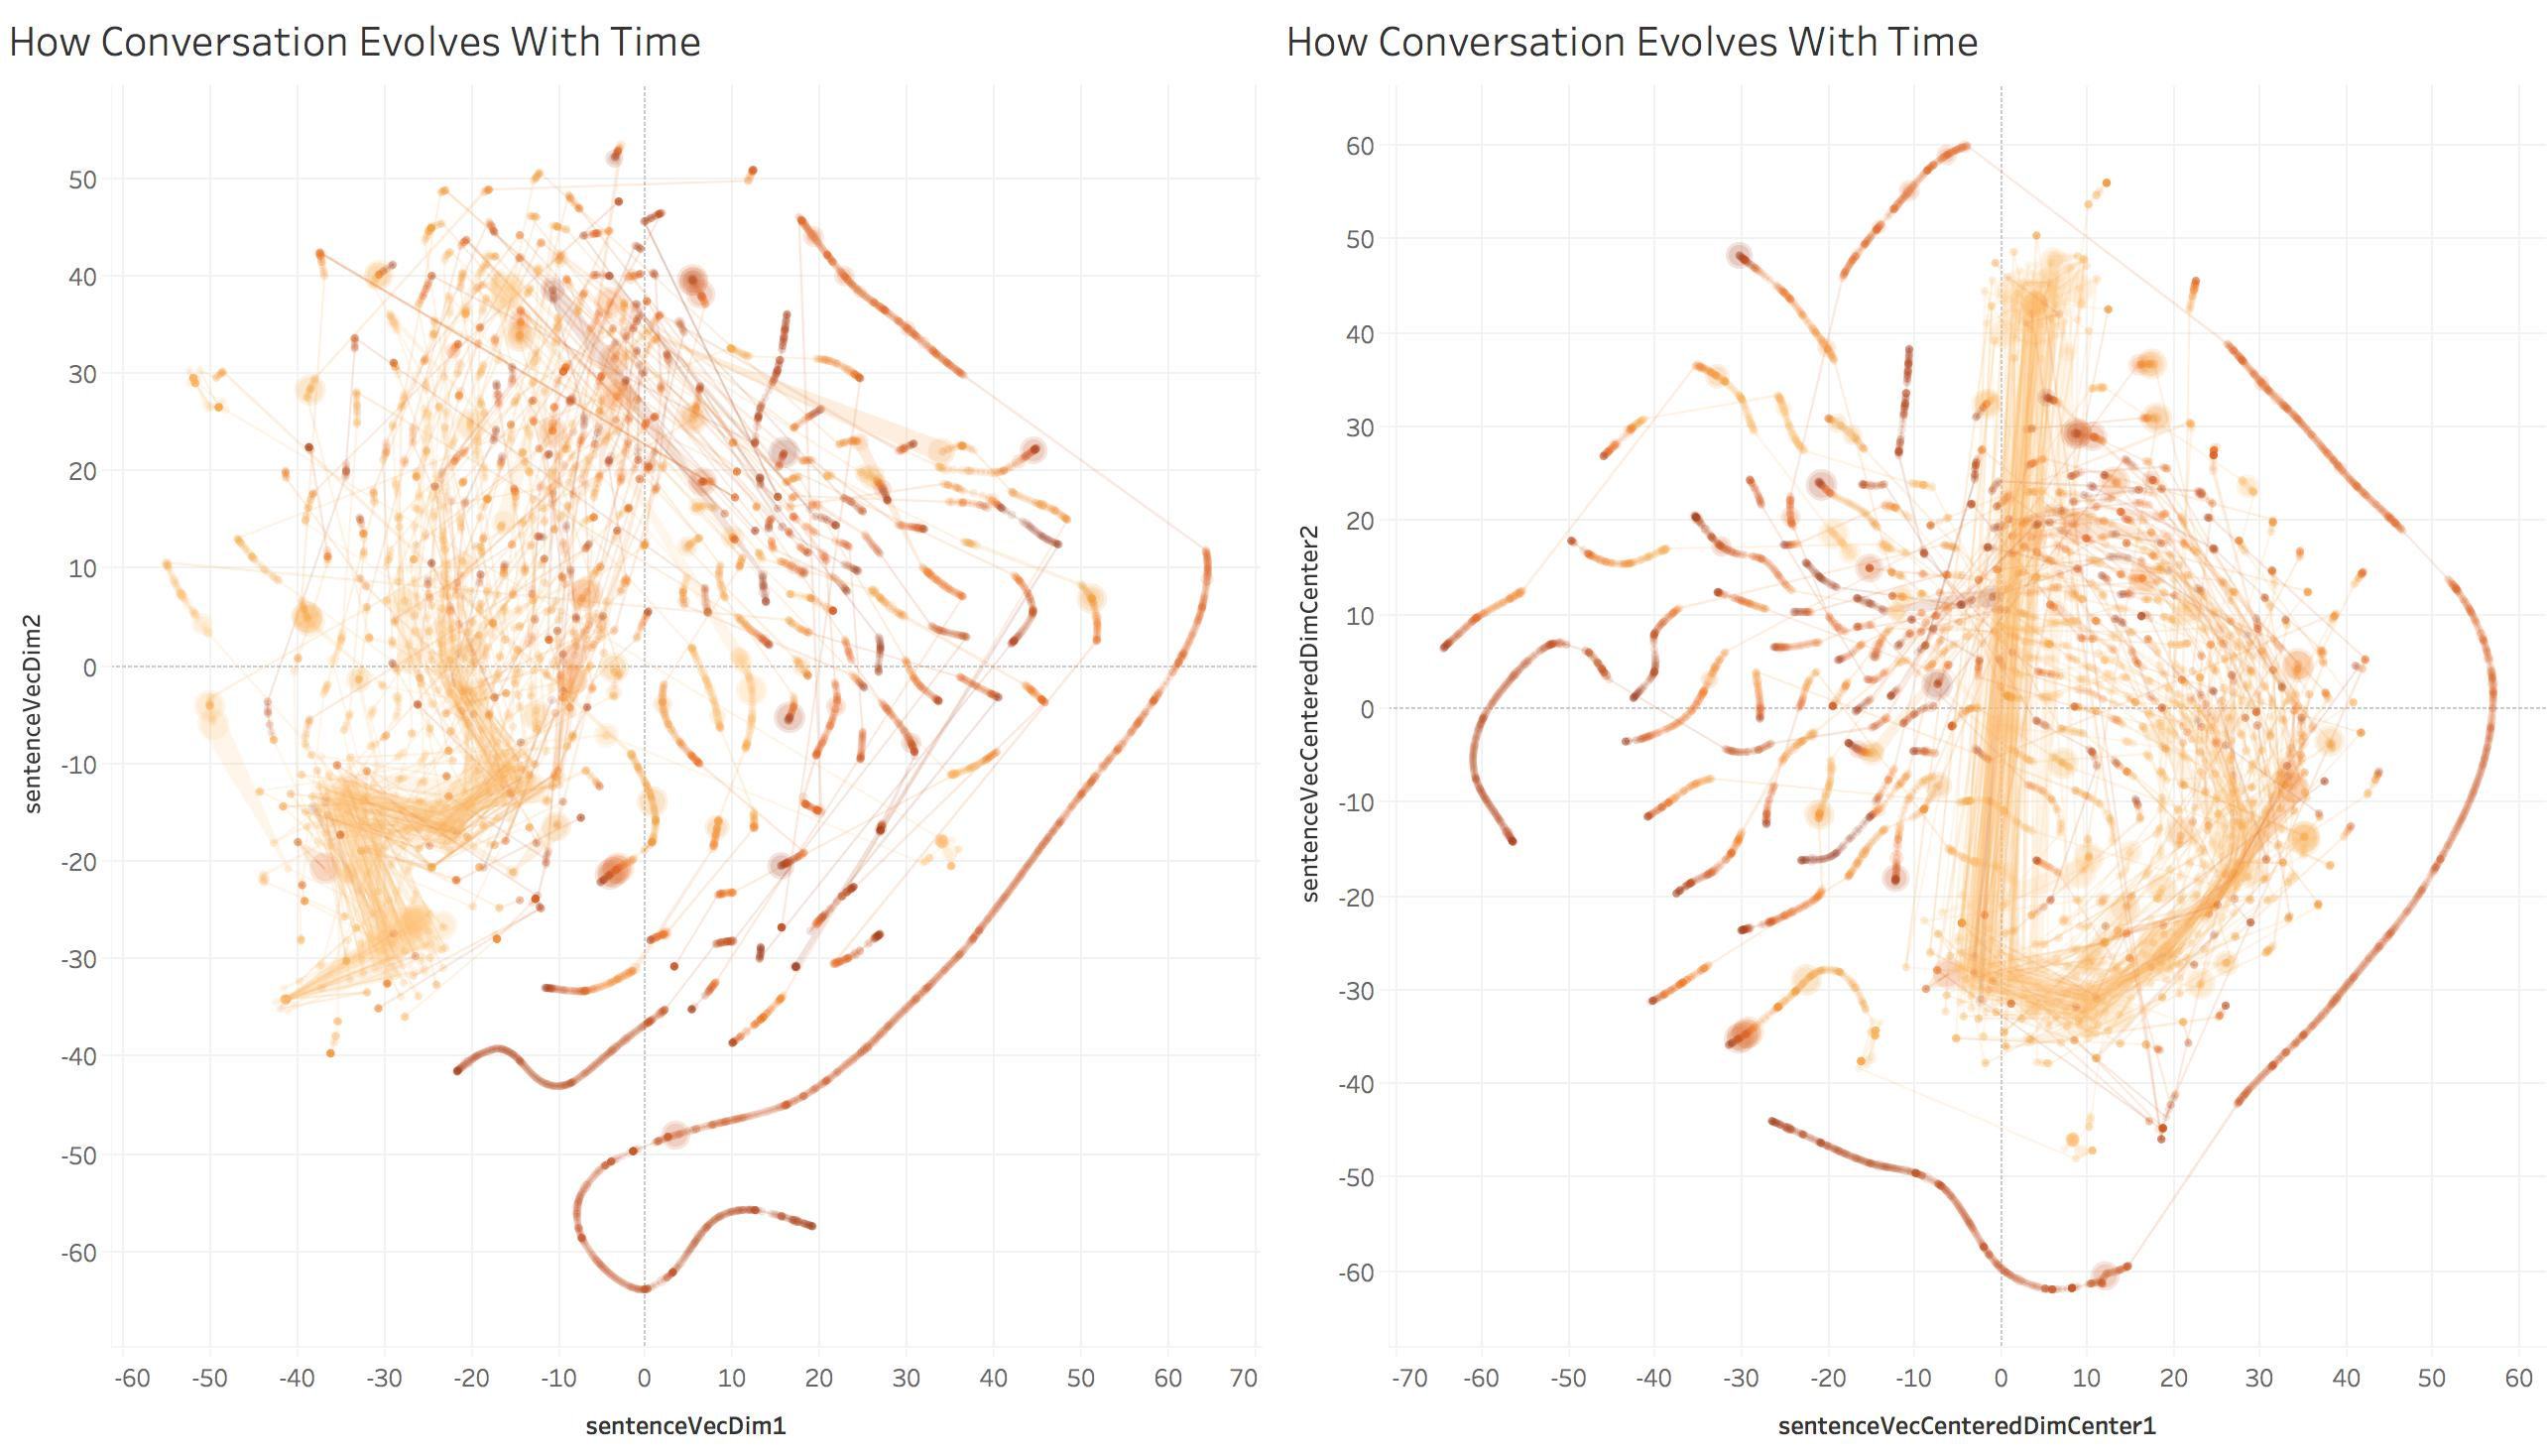

In [4]:
from IPython.display import Image
Image(filename='/home/ubuntu/wikipedia/Visualization/doc2vec_first_trial.jpg', retina=True)